In [60]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from concurrent.futures import ProcessPoolExecutor, as_completed

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

# 最大表示行数の指定（ここでは50行を指定）
pd.set_option('display.max_rows', 500)

In [61]:
train_df = pd.read_parquet('../data/feature_engineering_v8_train_df.parquet')
test_df = pd.read_parquet('../data/feature_engineering_v8_test_df.parquet')

train_label = pd.read_csv('../train_label.csv')
test_session = pd.read_csv('../test_session.csv')

train_log = pd.read_csv('../train_log.csv')
test_log = pd.read_csv('../test_log.csv')

In [62]:
train_df

,session_id,yado_no,target,predict_no,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd,popularity,overall_rank,wid_cd_rank,ken_cd_rank,lrg_cd_rank,sml_cd_rank,label_wid_cd,label_ken_cd,label_lrg_cd,label_sml_cd,count_wid_cd,count_ken_cd,count_lrg_cd,count_sml_cd,count_yado_no,fold,TE_wid_cd_mean,TE_wid_cd_var,TE_ken_cd_mean,TE_ken_cd_var,TE_lrg_cd_mean,TE_lrg_cd_var,TE_sml_cd_mean,TE_sml_cd_var,TE_yado_no_mean,TE_yado_no_var
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0,1,-1,0,1,-1,-1,0,0,205.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,212.0,364.0,40.0,3.0,1.0,1.0,4,6,8,11,335580,36215,13849,13529,881,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.037868,0.036485
1,000104bdffaaad1a1e0a9ebacf585f33,7749,0,2,-1,0,1,-1,-1,0,0,76.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,150.0,845.5,113.0,10.0,6.0,6.0,4,6,8,11,335580,36215,13849,13529,785,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.041860,0.040170
2,000104bdffaaad1a1e0a9ebacf585f33,902,0,3,-1,0,1,-1,-1,0,0,240.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,154.0,785.5,103.0,9.0,5.0,5.0,4,6,8,11,335580,36215,13849,13529,675,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.041742,0.040073
3,000104bdffaaad1a1e0a9ebacf585f33,11380,0,4,-1,0,1,-1,-1,0,0,111.0,1.0,0,1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,134.0,1114.0,143.0,16.0,12.0,12.0,4,6,8,11,335580,36215,13849,13529,671,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.032967,0.031939
4,000104bdffaaad1a1e0a9ebacf585f33,5490,0,5,-1,0,1,-1,-1,0,0,116.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,143.0,945.0,126.0,13.0,9.0,9.0,4,6,8,11,335580,36215,13849,13529,911,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.037037,0.035714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,0,5,-1,0,2,-1,-1,0,1,-1.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,50.0,4353.0,509.0,63.0,25.0,7.0,4,24,148,227,335580,38742,11787,2856,209,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.041722,0.039998,0.017964,0.017748
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,0,6,-1,0,2,-1,-1,0,0,198.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,138.0,1039.0,136.0,18.0,11.0,5.0,4,24,148,227,335580,38742,11787,2856,338,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.041722,0.039998,0.018450,0.018177
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,0,7,-1,0,2,-1,-1,0,0,94.0,1.0,1,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,840f2157ec5bb4f5501a3ace2f4ef8d1,120.0,1408.0,193.0,27.0,15.0,9.0,4,24,148,228,335580,38742,11787,8931,555,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.035605,0.034342,0.022624,0.022163
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,0,8,-1,0,2,-1,-1,0,0,310.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b0

In [63]:
print(train_df['seen_yad'].value_counts())
print(test_df['seen_yad'].value_counts())

0    2777527
Name: seen_yad, dtype: int64
0    1683604
Name: seen_yad, dtype: int64


### Optuna

In [5]:
import optuna
import numpy as np
import pandas as pd
from sklearn.metrics import label_ranking_average_precision_score
from catboost import CatBoostRanker, Pool

# 特徴量とターゲットの定義
all_features = train_df.columns.to_list()
features= [x for x in all_features if x not in ('session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd', 'seen_yad', 'TE_wid_cd', 'TE_ken_cd', 'TE_lrg_cd', 'TE_sml_cd', 'TE_yado_no')] # seen_yadも入れる 
cat_cols = ['yado_no']+ ['label_wid_cd', 'label_ken_cd', 'label_lrg_cd', 'label_sml_cd'] 
target = 'target'  # ターゲット変数の列名
query_ids =  'session_id' #train_df['session_id'].values  # クエリIDの列名

In [12]:
def objective(trial):
    params = {
        #'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0),
        'border_count': trial.suggest_int('border_count', 50, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 1e-2, 10.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        #'max_bin': trial.suggest_int('max_bin', 200, 400),
        # その他のパラメータ
        "cat_features": cat_cols,
        'task_type': 'GPU',  # GPUを使用するための設定
    }

    # ここで、CatBoostRankerの訓練と評価のコードを実行します。
    # ...
    map_scores = []
    for fold in range(5):
        # トレーニングデータとバリデーションデータの分割
        train_data = train_df[train_df['fold'] != fold]
        valid_data = train_df[train_df['fold'] == fold]

        # データセットの作成
        train_pool = Pool(data=train_data[features], label=train_data[target], group_id=train_data[query_ids], cat_features=cat_cols)
        val_pool = Pool(data=valid_data[features], label=valid_data[target], group_id=valid_data[query_ids], cat_features=cat_cols)

        # モデルの訓練
        model = CatBoostRanker(**params)
        model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, verbose=True)

        # バリデーションデータでの予測と評価
        valid_pred = model.predict(val_pool)
        map_score = label_ranking_average_precision_score([valid_data[target].values], [valid_pred])
        map_scores.append(map_score)
        
    
    return np.mean(map_scores)  # 試行の結果としてMAPスコアの平均を返します。


In [13]:
# Optunaのスタディを作成
study = optuna.create_study(direction='maximize')
# 15分で最適化を終了する
study.optimize(objective, timeout=600)
# 最適なパラメータを表示
print('Best trial:', study.best_trial.params)

[I 2023-12-16 13:15:25,245] A new study created in memory with name: no-name-fe2bb481-5775-4424-915d-b61dc641ea28


Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1943298	best: 0.1943298 (0)	total: 115ms	remaining: 1m 54s
1:	test: 0.1982323	best: 0.1982323 (1)	total: 224ms	remaining: 1m 51s
2:	test: 0.1982323	best: 0.1982323 (1)	total: 332ms	remaining: 1m 50s
3:	test: 0.1986387	best: 0.1986387 (3)	total: 439ms	remaining: 1m 49s
4:	test: 0.2008057	best: 0.2008057 (4)	total: 547ms	remaining: 1m 48s
5:	test: 0.2016555	best: 0.2016555 (5)	total: 654ms	remaining: 1m 48s
6:	test: 0.2108372	best: 0.2108372 (6)	total: 764ms	remaining: 1m 48s
7:	test: 0.2109198	best: 0.2109198 (7)	total: 871ms	remaining: 1m 48s
8:	test: 0.2109045	best: 0.2109198 (7)	total: 997ms	remaining: 1m 49s
9:	test: 0.2109201	best: 0.2109201 (9)	total: 1.11s	remaining: 1m 49s
10:	test: 0.2109239	best: 0.2109239 (10)	total: 1.22s	remaining: 1m 49s
11:	test: 0.2108811	best: 0.2109239 (10)	total: 1.32s	remaining: 1m 49s
12:	test: 0.2123351	best: 0.2123351 (12)	total: 1.43s	remaining: 1m 48s
13:	test: 0.2123190	best: 0.2123351 (12)	total: 1.54s	remaining: 1m 48s
14:	test: 0.

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1960531	best: 0.1960531 (0)	total: 118ms	remaining: 1m 57s
1:	test: 0.2015035	best: 0.2015035 (1)	total: 233ms	remaining: 1m 56s
2:	test: 0.2016858	best: 0.2016858 (2)	total: 342ms	remaining: 1m 53s
3:	test: 0.2023703	best: 0.2023703 (3)	total: 449ms	remaining: 1m 51s
4:	test: 0.2023369	best: 0.2023703 (3)	total: 557ms	remaining: 1m 50s
5:	test: 0.2023311	best: 0.2023703 (3)	total: 664ms	remaining: 1m 50s
6:	test: 0.2022998	best: 0.2023703 (3)	total: 773ms	remaining: 1m 49s
7:	test: 0.2023274	best: 0.2023703 (3)	total: 882ms	remaining: 1m 49s
8:	test: 0.2023686	best: 0.2023703 (3)	total: 991ms	remaining: 1m 49s
9:	test: 0.2023893	best: 0.2023893 (9)	total: 1.1s	remaining: 1m 48s
10:	test: 0.2023739	best: 0.2023893 (9)	total: 1.21s	remaining: 1m 48s
11:	test: 0.2023753	best: 0.2023893 (9)	total: 1.31s	remaining: 1m 48s
12:	test: 0.2023753	best: 0.2023893 (9)	total: 1.42s	remaining: 1m 48s
13:	test: 0.2023750	best: 0.2023893 (9)	total: 1.53s	remaining: 1m 47s
14:	test: 0.20238

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1944242	best: 0.1944242 (0)	total: 114ms	remaining: 1m 53s
1:	test: 0.2004009	best: 0.2004009 (1)	total: 223ms	remaining: 1m 51s
2:	test: 0.2008137	best: 0.2008137 (2)	total: 333ms	remaining: 1m 50s
3:	test: 0.2011339	best: 0.2011339 (3)	total: 441ms	remaining: 1m 49s
4:	test: 0.2011334	best: 0.2011339 (3)	total: 550ms	remaining: 1m 49s
5:	test: 0.2011619	best: 0.2011619 (5)	total: 657ms	remaining: 1m 48s
6:	test: 0.2011524	best: 0.2011619 (5)	total: 766ms	remaining: 1m 48s
7:	test: 0.2017263	best: 0.2017263 (7)	total: 875ms	remaining: 1m 48s
8:	test: 0.2016580	best: 0.2017263 (7)	total: 991ms	remaining: 1m 49s
9:	test: 0.2016563	best: 0.2017263 (7)	total: 1.1s	remaining: 1m 48s
10:	test: 0.2016486	best: 0.2017263 (7)	total: 1.21s	remaining: 1m 48s
11:	test: 0.2108368	best: 0.2108368 (11)	total: 1.32s	remaining: 1m 48s
12:	test: 0.2111737	best: 0.2111737 (12)	total: 1.43s	remaining: 1m 48s
13:	test: 0.2111688	best: 0.2111737 (12)	total: 1.53s	remaining: 1m 48s
14:	test: 0.21

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1966304	best: 0.1966304 (0)	total: 121ms	remaining: 2m 1s
1:	test: 0.1972215	best: 0.1972215 (1)	total: 242ms	remaining: 2m
2:	test: 0.1972404	best: 0.1972404 (2)	total: 357ms	remaining: 1m 58s
3:	test: 0.2016541	best: 0.2016541 (3)	total: 474ms	remaining: 1m 58s
4:	test: 0.2017140	best: 0.2017140 (4)	total: 590ms	remaining: 1m 57s
5:	test: 0.2017155	best: 0.2017155 (5)	total: 705ms	remaining: 1m 56s
6:	test: 0.2017125	best: 0.2017155 (5)	total: 822ms	remaining: 1m 56s
7:	test: 0.2017125	best: 0.2017155 (5)	total: 940ms	remaining: 1m 56s
8:	test: 0.2017141	best: 0.2017155 (5)	total: 1.06s	remaining: 1m 56s
9:	test: 0.2017146	best: 0.2017155 (5)	total: 1.17s	remaining: 1m 56s
10:	test: 0.2065580	best: 0.2065580 (10)	total: 1.29s	remaining: 1m 55s
11:	test: 0.2066676	best: 0.2066676 (11)	total: 1.4s	remaining: 1m 55s
12:	test: 0.2066695	best: 0.2066695 (12)	total: 1.52s	remaining: 1m 55s
13:	test: 0.2137931	best: 0.2137931 (13)	total: 1.64s	remaining: 1m 55s
14:	test: 0.214420

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1991063	best: 0.1991063 (0)	total: 123ms	remaining: 2m 2s
1:	test: 0.1990887	best: 0.1991063 (0)	total: 245ms	remaining: 2m 2s
2:	test: 0.2000422	best: 0.2000422 (2)	total: 362ms	remaining: 2m
3:	test: 0.2000627	best: 0.2000627 (3)	total: 477ms	remaining: 1m 58s
4:	test: 0.2045107	best: 0.2045107 (4)	total: 591ms	remaining: 1m 57s
5:	test: 0.2045021	best: 0.2045107 (4)	total: 705ms	remaining: 1m 56s
6:	test: 0.2044929	best: 0.2045107 (4)	total: 821ms	remaining: 1m 56s
7:	test: 0.2057794	best: 0.2057794 (7)	total: 937ms	remaining: 1m 56s
8:	test: 0.2145937	best: 0.2145937 (8)	total: 1.05s	remaining: 1m 56s
9:	test: 0.2144731	best: 0.2145937 (8)	total: 1.17s	remaining: 1m 55s
10:	test: 0.2144809	best: 0.2145937 (8)	total: 1.29s	remaining: 1m 55s
11:	test: 0.2146119	best: 0.2146119 (11)	total: 1.4s	remaining: 1m 55s
12:	test: 0.2155745	best: 0.2155745 (12)	total: 1.52s	remaining: 1m 55s
13:	test: 0.2156104	best: 0.2156104 (13)	total: 1.64s	remaining: 1m 55s
14:	test: 0.2156818	

[I 2023-12-16 13:26:01,863] Trial 0 finished with value: 0.06807599834246088 and parameters: {'depth': 6, 'l2_leaf_reg': 2.246756724419057, 'border_count': 59, 'bagging_temperature': 0.8449143143831731, 'random_strength': 1.181436858740176, 'min_data_in_leaf': 94}. Best is trial 0 with value: 0.06807599834246088.


Best trial: {'depth': 6, 'l2_leaf_reg': 2.246756724419057, 'border_count': 59, 'bagging_temperature': 0.8449143143831731, 'random_strength': 1.181436858740176, 'min_data_in_leaf': 94}


### CatBoost Ranker

In [64]:
import numpy as np
import pandas as pd
from sklearn.metrics import label_ranking_average_precision_score
from catboost import CatBoostRanker, Pool

# 特徴量とターゲットの定義
all_features = train_df.columns.to_list()
features= [x for x in all_features if x not in ('session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd', 'seen_yad', 'TE_wid_cd', 'TE_ken_cd', 'TE_lrg_cd', 'TE_sml_cd', 'TE_yado_no')] # seen_yadも入れる 
cat_cols = ['yado_no']+ ['label_wid_cd', 'label_ken_cd', 'label_lrg_cd', 'label_sml_cd'] 
target = 'target'  # ターゲット変数の列名
query_ids =  'session_id' #train_df['session_id'].values  # クエリIDの列名

params = {
    'loss_function': 'YetiRank',  # YetiRankPairwise という選択肢もあります
    'learning_rate': 0.2,
    'iterations': 5000,
    'depth': 6, 
    'l2_leaf_reg': 2.246756724419057, 
    'border_count': 59, 
    'bagging_temperature': 0.8449143143831731, 
    'random_strength': 1.181436858740176, 
    'min_data_in_leaf': 94,
    "cat_features": cat_cols,
    'task_type': 'GPU',  # GPUを使用するための設定
}

In [65]:
map_scores = []  # 各foldのMAPスコアを保存するリスト
test_pred = []   # 各foldのテストデータの予測値を保存するリスト
oof_pred = np.zeros(len(train_df))  # OOF予測値用の配列を初期化

for fold in range(5):
    # トレーニングデータとバリデーションデータの分割
    train_data = train_df[train_df['fold'] != fold]
    valid_data = train_df[train_df['fold'] == fold]

    # データセットの作成
    train_pool = Pool(data=train_data[features], label=train_data[target], group_id=train_data[query_ids], cat_features=cat_cols)
    val_pool = Pool(data=valid_data[features], label=valid_data[target], group_id=valid_data[query_ids], cat_features=cat_cols)

    # モデルの訓練
    model = CatBoostRanker(**params)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, verbose=True)

    # バリデーションデータでの予測と評価
    valid_pred = model.predict(val_pool)
    oof_pred[valid_data.index] = valid_pred  # OOF予測値の保存

    # MAPスコアの計算
    map_score = label_ranking_average_precision_score([valid_data[target].values], [valid_pred])
    map_scores.append(map_score)
    print(f'Fold {fold}: MAP = {map_score}')

    # テストデータでの予測
    test_pred.append(model.predict(test_df[features]))

# 平均 MAP の計算
print(f'Mean MAP: {np.mean(map_scores)}')


Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1943298	best: 0.1943298 (0)	total: 117ms	remaining: 9m 46s
1:	test: 0.1982323	best: 0.1982323 (1)	total: 229ms	remaining: 9m 31s
2:	test: 0.2004795	best: 0.2004795 (2)	total: 336ms	remaining: 9m 20s
3:	test: 0.2121547	best: 0.2121547 (3)	total: 442ms	remaining: 9m 11s
4:	test: 0.2122106	best: 0.2122106 (4)	total: 545ms	remaining: 9m 4s
5:	test: 0.2124331	best: 0.2124331 (5)	total: 649ms	remaining: 9m
6:	test: 0.2136626	best: 0.2136626 (6)	total: 754ms	remaining: 8m 57s
7:	test: 0.2150374	best: 0.2150374 (7)	total: 858ms	remaining: 8m 55s
8:	test: 0.2161202	best: 0.2161202 (8)	total: 963ms	remaining: 8m 53s
9:	test: 0.2161199	best: 0.2161202 (8)	total: 1.07s	remaining: 8m 53s
10:	test: 0.2173778	best: 0.2173778 (10)	total: 1.18s	remaining: 8m 55s
11:	test: 0.2174543	best: 0.2174543 (11)	total: 1.28s	remaining: 8m 54s
12:	test: 0.2177932	best: 0.2177932 (12)	total: 1.39s	remaining: 8m 53s
13:	test: 0.2181376	best: 0.2181376 (13)	total: 1.49s	remaining: 8m 52s
14:	test: 0.21815

Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1960531	best: 0.1960531 (0)	total: 113ms	remaining: 9m 26s
1:	test: 0.1967354	best: 0.1967354 (1)	total: 220ms	remaining: 9m 9s
2:	test: 0.2012696	best: 0.2012696 (2)	total: 324ms	remaining: 8m 59s
3:	test: 0.2015974	best: 0.2015974 (3)	total: 426ms	remaining: 8m 52s
4:	test: 0.2063016	best: 0.2063016 (4)	total: 530ms	remaining: 8m 49s
5:	test: 0.2130863	best: 0.2130863 (5)	total: 634ms	remaining: 8m 47s
6:	test: 0.2163852	best: 0.2163852 (6)	total: 738ms	remaining: 8m 46s
7:	test: 0.2164671	best: 0.2164671 (7)	total: 843ms	remaining: 8m 45s
8:	test: 0.2165664	best: 0.2165664 (8)	total: 946ms	remaining: 8m 44s
9:	test: 0.2165132	best: 0.2165664 (8)	total: 1.05s	remaining: 8m 44s
10:	test: 0.2178853	best: 0.2178853 (10)	total: 1.15s	remaining: 8m 43s
11:	test: 0.2180408	best: 0.2180408 (11)	total: 1.26s	remaining: 8m 42s
12:	test: 0.2184115	best: 0.2184115 (12)	total: 1.36s	remaining: 8m 42s
13:	test: 0.2188829	best: 0.2188829 (13)	total: 1.47s	remaining: 8m 41s
14:	test: 0.2

Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1944242	best: 0.1944242 (0)	total: 114ms	remaining: 9m 28s
1:	test: 0.2078936	best: 0.2078936 (1)	total: 224ms	remaining: 9m 18s
2:	test: 0.2079201	best: 0.2079201 (2)	total: 331ms	remaining: 9m 11s
3:	test: 0.2101103	best: 0.2101103 (3)	total: 433ms	remaining: 9m 1s
4:	test: 0.2102133	best: 0.2102133 (4)	total: 540ms	remaining: 8m 59s
5:	test: 0.2102341	best: 0.2102341 (5)	total: 646ms	remaining: 8m 57s
6:	test: 0.2102862	best: 0.2102862 (6)	total: 752ms	remaining: 8m 56s
7:	test: 0.2109630	best: 0.2109630 (7)	total: 858ms	remaining: 8m 55s
8:	test: 0.2140380	best: 0.2140380 (8)	total: 970ms	remaining: 8m 57s
9:	test: 0.2151395	best: 0.2151395 (9)	total: 1.07s	remaining: 8m 56s
10:	test: 0.2161698	best: 0.2161698 (10)	total: 1.18s	remaining: 8m 55s
11:	test: 0.2165495	best: 0.2165495 (11)	total: 1.29s	remaining: 8m 54s
12:	test: 0.2180277	best: 0.2180277 (12)	total: 1.39s	remaining: 8m 54s
13:	test: 0.2181308	best: 0.2181308 (13)	total: 1.5s	remaining: 8m 53s
14:	test: 0.21

Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1966304	best: 0.1966304 (0)	total: 118ms	remaining: 9m 49s
1:	test: 0.1972317	best: 0.1972317 (1)	total: 229ms	remaining: 9m 31s
2:	test: 0.2016732	best: 0.2016732 (2)	total: 337ms	remaining: 9m 22s
3:	test: 0.2117084	best: 0.2117084 (3)	total: 445ms	remaining: 9m 16s
4:	test: 0.2142478	best: 0.2142478 (4)	total: 555ms	remaining: 9m 14s
5:	test: 0.2142200	best: 0.2142478 (4)	total: 664ms	remaining: 9m 12s
6:	test: 0.2141595	best: 0.2142478 (4)	total: 771ms	remaining: 9m 9s
7:	test: 0.2153090	best: 0.2153090 (7)	total: 881ms	remaining: 9m 9s
8:	test: 0.2162714	best: 0.2162714 (8)	total: 990ms	remaining: 9m 8s
9:	test: 0.2168570	best: 0.2168570 (9)	total: 1.1s	remaining: 9m 7s
10:	test: 0.2167476	best: 0.2168570 (9)	total: 1.21s	remaining: 9m 7s
11:	test: 0.2177348	best: 0.2177348 (11)	total: 1.31s	remaining: 9m 6s
12:	test: 0.2181147	best: 0.2181147 (12)	total: 1.42s	remaining: 9m 6s
13:	test: 0.2182960	best: 0.2182960 (13)	total: 1.53s	remaining: 9m 5s
14:	test: 0.2185460	be

Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1991063	best: 0.1991063 (0)	total: 114ms	remaining: 9m 28s
1:	test: 0.1990887	best: 0.1991063 (0)	total: 219ms	remaining: 9m 8s
2:	test: 0.2040497	best: 0.2040497 (2)	total: 322ms	remaining: 8m 57s
3:	test: 0.2150629	best: 0.2150629 (3)	total: 428ms	remaining: 8m 53s
4:	test: 0.2150155	best: 0.2150629 (3)	total: 533ms	remaining: 8m 52s
5:	test: 0.2151447	best: 0.2151447 (5)	total: 638ms	remaining: 8m 51s
6:	test: 0.2164953	best: 0.2164953 (6)	total: 744ms	remaining: 8m 50s
7:	test: 0.2208706	best: 0.2208706 (7)	total: 863ms	remaining: 8m 58s
8:	test: 0.2207029	best: 0.2208706 (7)	total: 968ms	remaining: 8m 56s
9:	test: 0.2216370	best: 0.2216370 (9)	total: 1.07s	remaining: 8m 55s
10:	test: 0.2219773	best: 0.2219773 (10)	total: 1.18s	remaining: 8m 57s
11:	test: 0.2227049	best: 0.2227049 (11)	total: 1.29s	remaining: 8m 56s
12:	test: 0.2225449	best: 0.2227049 (11)	total: 1.4s	remaining: 8m 55s
13:	test: 0.2232429	best: 0.2232429 (13)	total: 1.5s	remaining: 8m 54s
14:	test: 0.223

              Feature Id   Importances
0             predict_no  2.662410e-02
1        TE_yado_no_mean  9.946936e-03
2          count_yado_no  7.161257e-03
3             max_seq_no  5.344379e-03
4         TE_yado_no_var  3.328806e-03
5         total_room_cnt  3.160114e-03
6                yado_no  2.461286e-03
7            sml_cd_rank  4.905353e-04
8              onsen_flg  3.648763e-04
9            wid_cd_rank  3.460842e-04
10           lrg_cd_rank  3.119001e-04
11           ken_cd_rank  2.459390e-04
12            popularity  1.858619e-04
13          count_ken_cd  1.364510e-04
14     kd_conv_walk_5min  1.224140e-04
15           kd_stn_5min  1.204129e-04
16        TE_ken_cd_mean  1.110679e-04
17          count_sml_cd  9.681882e-05
18         TE_wid_cd_var  9.276582e-05
19          label_sml_cd  8.702839e-05
20         TE_sml_cd_var  6.324597e-05
21      wireless_lan_flg  6.010848e-05
22          count_wid_cd  4.938270e-05
23        TE_lrg_cd_mean  4.315869e-05
24        TE_wid_cd_mean 

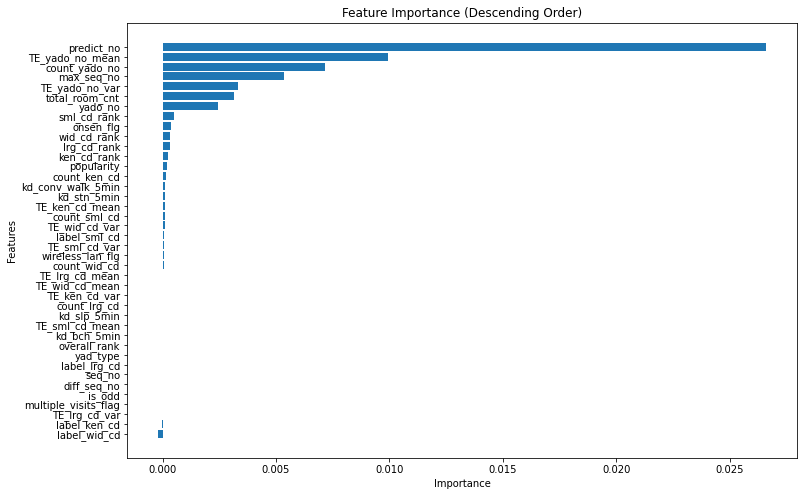

In [16]:
import matplotlib.pyplot as plt

# トレーニングデータセットでのPoolを作成（もしまだ作成していない場合）
#train_pool = Pool(data=train_data[features], label=train_data[target], group_id=train_data[query_ids])

# 特徴量の重要度を取得（トレーニングデータセットを使用）
feature_importances = model.get_feature_importance(train_pool, prettified=True)

# 特徴量の重要度を降順に並び替え
feature_importances.sort_values(by='Importances', ascending=False, inplace=True)

# 特徴量の重要度を表示
print(feature_importances)

# 特徴量の重要度をグラフで表示（降順）
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature Id'], feature_importances['Importances'])
plt.gca().invert_yaxis()  # y軸を逆順にして、重要度が高い特徴量を上に表示
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance (Descending Order)')
plt.show()

In [66]:
# train_dfのyado_noをyad_noに変更
train_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [68]:
train_df['oof_pred'] = oof_pred
train_df[['session_id', 'yad_no', 'oof_pred']].head()

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,1.128563
1,000104bdffaaad1a1e0a9ebacf585f33,7749,0.110568
2,000104bdffaaad1a1e0a9ebacf585f33,902,0.322023
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.090348
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-1.291555


In [69]:
train_df[['session_id', 'yad_no', 'oof_pred']]

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,1.128563
1,000104bdffaaad1a1e0a9ebacf585f33,7749,0.110568
2,000104bdffaaad1a1e0a9ebacf585f33,902,0.322023
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.090348
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-1.291555
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-2.336933
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-2.364821
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-1.528846
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-2.928363


In [70]:
oof_pred_df = train_df[['session_id', 'yad_no', 'oof_pred']]
oof_pred_df

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,1.128563
1,000104bdffaaad1a1e0a9ebacf585f33,7749,0.110568
2,000104bdffaaad1a1e0a9ebacf585f33,902,0.322023
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.090348
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-1.291555
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-2.336933
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-2.364821
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-1.528846
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-2.928363


In [73]:
# アンサンブル用にoof_predを保存
oof_pred_df.to_csv('../ensemble/catRanker_ver7_oof_pred.csv', index=False)

In [72]:
oof_pred_df

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,1.128563
1,000104bdffaaad1a1e0a9ebacf585f33,7749,0.110568
2,000104bdffaaad1a1e0a9ebacf585f33,902,0.322023
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.090348
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-1.291555
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-2.336933
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-2.364821
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-1.528846
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-2.928363


### CVの計算

In [23]:
train_log_df = pd.read_csv('../train_log.csv')
train_label_df = pd.read_csv('../train_label.csv')

In [24]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
oof_pred_df = oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
oof_pred_df.set_index('session_id', inplace=True)

In [25]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = '000104bdffaaad1a1e0a9ebacf585f33'
recommendations = get_top_recommendations(session_id_to_check, oof_pred_df)
print(recommendations)

[3894, 902, 7749, 11380, 1284, 12491, 254, 5490, 4072]
CPU times: user 154 ms, sys: 0 ns, total: 154 ms
Wall time: 153 ms


In [26]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = train_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = train_label_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(train_label_df))}
    for future in tqdm(as_completed(future_to_session), total=len(train_label_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 288698/288698 [00:45<00:00, 6415.14it/s]


In [27]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
result_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
result_df.columns = [f'predict_{i}' for i in range(result_df.shape[1])]
# 最初の列にセッションIDを追加する
# result_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
result_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,4101,2808,997,5289,12846,3324,11882,9208,9207,9209
1,8253,4488,2570,8747,11104,2259,1586,3725,3564,8225
2,4863,5238,13642,2957,9039,4355,1967,6722,11724,7509
3,626,13549,755,2272,109,7812,7872,11715,1341,13296
4,96,3894,902,7749,11380,1284,12491,254,5490,4072
...,...,...,...,...,...,...,...,...,...,...
288693,10955,13210,5719,13079,3725,10522,13717,1586,8677,2876
288694,963,4767,2900,513,5299,8703,8465,399,6654,3940
288695,3566,4398,10364,7308,7820,2087,4040,9558,12240,844
288696,10619,570,12500,11091,7551,3238,10616,12781,12829,11316


### 要素の集合にバグがないかを確認

In [28]:
candidate_ver15_train = pd.read_csv('../data/candidate_ver15_train.csv')

In [29]:
# 既存のDataFrameを読み込む
df1 = candidate_ver15_train
df2 = result_df#.drop(columns=['has_duplicates'])
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)


0


### 順位変動のあったカラムを確認する

In [30]:
candidate_ver15_train

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
...,...,...,...,...,...,...,...,...,...,...
288693,13210,13079,2876,3725,8677,13717,1586,10955,10522,5719
288694,8703,3940,399,4767,2900,6654,5299,8465,963,513
288695,7308,12240,4040,7820,4398,2087,9558,3566,844,10364
288696,10619,570,12500,11091,7551,3238,10616,12781,12829,11316


In [31]:
# 各要素が一致しているかどうかをチェック
diff = candidate_ver15_train != result_df

# 一致していない行のインデックスを抽出
mismatched_indices = diff.any(axis=1)
mismatched_rows = candidate_ver15_train[mismatched_indices]

print("一致していない行のインデックス：")
print(mismatched_indices)
print("一致していない行：")
print(len(mismatched_rows))

一致していない行のインデックス：
0          True
1          True
2          True
3          True
4          True
          ...  
288693     True
288694     True
288695     True
288696    False
288697     True
Length: 288698, dtype: bool
一致していない行：
285658


In [32]:
candidate_ver15_train[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
5,10510,4823,12544,5369,1,9207,9199,9200,9201,9202
6,7531,441,2480,13240,10378,2282,7273,10442,12774,4574
7,4744,9508,7681,10362,12962,1755,12125,12464,111,10544
8,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
9,10478,379,550,3278,3483,6592,9773,9430,4303,2806


In [33]:
result_df[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,4101,2808,997,5289,12846,3324,11882,9208,9207,9209
1,8253,4488,2570,8747,11104,2259,1586,3725,3564,8225
2,4863,5238,13642,2957,9039,4355,1967,6722,11724,7509
3,626,13549,755,2272,109,7812,7872,11715,1341,13296
4,96,3894,902,7749,11380,1284,12491,254,5490,4072
5,4823,12544,10510,5369,9207,9199,9201,9200,9202,1
6,4574,7531,10378,10442,12774,441,2480,7273,2282,13240
7,111,10362,4744,12962,12464,9508,12125,10544,1755,7681
8,899,3802,3644,4014,1227,9723,12432,13220,13702,2164
9,10478,6592,379,3278,3483,550,2806,4303,9773,9430


In [34]:
y_true = train_label['yad_no'].values.reshape(-1, 1)
y_pred = result_df.values

In [35]:
# Recall(候補にあげたものが)のy_trueに含まれているものの割合

# マッチするかどうかをチェックするリストを初期化
matches = []

# y_pred の各サブアレイと y_true の値を比較
for pred, true in zip(y_pred, y_true):
    # pred はサブアレイ、true は値
    matches.append(int(true in pred))

# matches は、指定された条件に基づいて 0 と 1 のリストです
print(matches)

# matches は先のステップで生成した 0 と 1 のリストです。
# 1 の割合を計算
one_ratio = sum(matches) / len(matches)

# 割合をプリント
print("Recall is: {:.2%}".format(one_ratio))

[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 

In [36]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the AP at k between two lists of items.
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean AP at k between two lists of list of items.
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

# y_true と y_pred をリストに変換
y_true_list = [list(x) for x in y_true]
y_pred_list = [list(x) for x in y_pred]

# MAP@10 を計算
map_at_10 = mapk(y_true_list, y_pred_list, k=10)
print(f'Map@10  {map_at_10}')

Map@10  0.462715792314196


In [37]:
# 各行内で重複があるかどうかをチェック
def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
result_df['has_duplicates'] = result_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = result_df[result_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [38]:
# 欠損がないかをチェック
result_df.isnull().sum(axis=1).sum()

0

In [39]:
result_df.head()

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,has_duplicates
0,4101,2808,997,5289,12846,3324,11882,9208,9207,9209,False
1,8253,4488,2570,8747,11104,2259,1586,3725,3564,8225,False
2,4863,5238,13642,2957,9039,4355,1967,6722,11724,7509,False
3,626,13549,755,2272,109,7812,7872,11715,1341,13296,False
4,96,3894,902,7749,11380,1284,12491,254,5490,4072,False


### 推論用の候補テーブルを作成する

In [74]:
test_log_df = pd.read_csv('../test_log.csv')
test_session_df = pd.read_csv('../test_session.csv')

In [75]:
print(np.mean(test_pred, axis=0))  # 各foldのテストデータの予測値の平均をとる
print(len(np.mean(test_pred, axis=0)))

[1.12606888 0.27821611 0.46493765 ... 0.10335851 0.07243327 0.24759608]
1683604


In [76]:
# test_predの形を調べる
print(np.array(test_pred).shape)

(5, 1683604)


In [77]:
# test_dfのyado_noをyad_noに変更
test_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [78]:
test_df['target'] = np.mean(test_pred, axis=0)
test_df[['session_id', 'yad_no', 'target']].head()

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,1.126069
1,00001149e9c73985425197104712478c,4714,0.278216
2,00001149e9c73985425197104712478c,2680,0.464938
3,00001149e9c73985425197104712478c,4420,-0.487085
4,00001149e9c73985425197104712478c,5466,-0.428085


In [79]:
test_oof_pred_df = test_df[['session_id', 'yad_no', 'target']]
test_oof_pred_df

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,1.126069
1,00001149e9c73985425197104712478c,4714,0.278216
2,00001149e9c73985425197104712478c,2680,0.464938
3,00001149e9c73985425197104712478c,4420,-0.487085
4,00001149e9c73985425197104712478c,5466,-0.428085
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.315336
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.186797
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,0.103359
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,0.072433


In [80]:
# test_oof_pred_dfのカラム名を変更
test_oof_pred_df.rename(columns={'target': 'oof_pred'}, inplace=True)
test_oof_pred_df

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,1.126069
1,00001149e9c73985425197104712478c,4714,0.278216
2,00001149e9c73985425197104712478c,2680,0.464938
3,00001149e9c73985425197104712478c,4420,-0.487085
4,00001149e9c73985425197104712478c,5466,-0.428085
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.315336
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.186797
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,0.103359
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,0.072433


In [81]:
test_oof_pred_df

,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,1.126069
1,00001149e9c73985425197104712478c,4714,0.278216
2,00001149e9c73985425197104712478c,2680,0.464938
3,00001149e9c73985425197104712478c,4420,-0.487085
4,00001149e9c73985425197104712478c,5466,-0.428085
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.315336
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.186797
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,0.103359
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,0.072433


In [82]:
# アンサンブル用にoof_predを保存
test_oof_pred_df.to_csv('../ensemble/catRanker_ver7_test_pred.csv', index=False)

In [49]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
test_oof_pred_df = test_oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
test_oof_pred_df.set_index('session_id', inplace=True)

In [50]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = 'ffffe984aafd6127ce8e43e3ca40c79d'
recommendations = get_top_recommendations(session_id_to_check, test_oof_pred_df)
print(recommendations)

[11723, 5623, 10729, 1891, 12767, 12620, 3781, 11994, 634, 867]
CPU times: user 96.4 ms, sys: 33 µs, total: 96.4 ms
Wall time: 96.5 ms


In [51]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = test_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = test_session_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=test_oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(test_session_df))}
    for future in tqdm(as_completed(future_to_session), total=len(test_session_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 174700/174700 [00:27<00:00, 6413.71it/s]


In [52]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
test_expanded_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
test_expanded_df.columns = [f'predict_{i}' for i in range(test_expanded_df.shape[1])]
# 最初の列にセッションIDを追加する
# expanded_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,2680,4714,5466,4420,9830,9534,6563,5785
1,143,7014,8108,11923,6555,613,4066,6129,11237,12862
2,757,9190,7710,9910,1774,6721,10485,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,6489,10746
4,10826,9020,9623,3476,2862,3854,12029,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,7062,10997,2278,10042,9743,3440
174696,13702,4014,3802,899,1227,9723,3644,2164,13220,12432
174697,12939,13241,13719,13797,5810,7308,2087,8143,11037,11796
174698,3100,1687,10287,2692,2373,3002,4976,13672,5513,12281


In [53]:
# 各行内で重複があるかどうかをチェック

def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
test_expanded_df['has_duplicates'] = test_expanded_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = test_expanded_df[test_expanded_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [54]:
# 欠損がないかをチェック
test_expanded_df.isnull().sum(axis=1).sum()

0

In [55]:
candidate_ver15_test = pd.read_csv('../data/candidate_ver15_test.csv')
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [56]:
# 行ごとに要素の集合が異なっていないかをチェック
import pandas as pd

# 既存のDataFrameを読み込む
df1 = candidate_ver15_test
df2 = test_expanded_df.drop('has_duplicates', axis=1)
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)

0


In [57]:
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [58]:
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,has_duplicates
0,3560,11561,2680,4714,5466,4420,9830,9534,6563,5785,False
1,143,7014,8108,11923,6555,613,4066,6129,11237,12862,False
2,757,9190,7710,9910,1774,6721,10485,410,13570,6730,False
3,12341,3359,6991,1542,13521,5080,10861,4180,6489,10746,False
4,10826,9020,9623,3476,2862,3854,12029,3844,5372,6161,False
...,...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,7062,10997,2278,10042,9743,3440,False
174696,13702,4014,3802,899,1227,9723,3644,2164,13220,12432,False
174697,12939,13241,13719,13797,5810,7308,2087,8143,11037,11796,False
174698,3100,1687,10287,2692,2373,3002,4976,13672,5513,12281,False


In [59]:
test_expanded_df.drop(columns=['has_duplicates']).to_csv('../submissions/catRanker_ver7.csv', index=False)